# Model Construction

in this notebook, we will construct the model for the Goal-conditioned policy using a supervised learning approach. We will use the data collected from expert demonstrations to train the model. The model will be used to predict the next state given the current state and the goal state. The model will be used to generate the goal-conditioned policy.

This algorithm is inspired by the paper [Learning to Reach Goals via Iterated Supervised Learning](https://arxiv.org/abs/1912.06088) and the [GCSL code](https://github.com/dibyaghosh/gcsl)

In [1]:
# imports
import os
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.obs_utils as ObsUtils
import helper
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch
import bc_gcsl_model

# change this to the path of the project
%cd /project
%load_ext autoreload
%autoreload 2

/project


In [2]:
# Project directory structure
ROOT_DIR = os.getcwd()
WS_DIR = os.path.join(ROOT_DIR, "src/")
DATA_DIR = os.path.join(ROOT_DIR, "data/")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [3]:
## download the dataset
# user parameters
task_0 = "lift"
task_1 = "can"
dataset_type = "ph"
hdf5_type = "low_dim"

# download the dataset
lift_data_path = helper.download_dataset(task_0, dataset_type, hdf5_type, DATA_DIR+task_0)
can_data_path = helper.download_dataset(task_1, dataset_type, hdf5_type, DATA_DIR+task_1)

## Data loaders

In [4]:
# Aggregate the data from all the demonstrations/trajectories
# task_id = 0 for lift and task_id = 1 for can
lift_inputs, lift_actions = helper.aggregate_data(hdf5_path=lift_data_path, task_id=0)
can_inputs, can_actions = helper.aggregate_data(hdf5_path=can_data_path, task_id=1)

# Combine the inputs and actions from both tasks
combined_data = list(zip(lift_inputs, lift_actions)) + list(zip(can_inputs, can_actions))

In [5]:
# Create the combined dataset and DataLoader
dataset = helper.CombinedDataset(combined_data)
def custom_collate(batch):
    return batch

# Use the custom collate function in your DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate)

## Model

In [6]:
# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
## Setting encoders size for the tasks
# task: lift
lift_input_dim = lift_inputs.shape[1] # 19 (state) + 19 (goal) + 1 (task identifier)
# task: can
can_input_dim = can_inputs.shape[1] # 23 (state) + 23 (goal) + 1 (task identifier)
# setting the encoder
list_of_input_sizes = [lift_input_dim, can_input_dim]
encoder = bc_gcsl_model.DynamicEncoder(list_of_input_sizes)

## Setting the model
action_dim = lift_actions.shape[1]
model = bc_gcsl_model.CustomBCModel(encoder, action_dim).to(device)

## Training

In [32]:
for batch in dataloader:
    # Load data
    for inputs, actions in batch:
        print(inputs.shape)
        print(inputs)
        break
    break

torch.Size([47])
tensor([ 1.8418e-01, -3.4583e-01,  9.3113e-01,  9.5411e-01,  2.9841e-01,
         1.4024e-02,  2.0820e-02,  3.9246e-02, -3.9724e-02,  1.9044e-01,
        -3.7632e-01,  8.6005e-01, -2.6889e-04, -1.5814e-04,  3.5119e-02,
        -9.9938e-01, -1.3253e-02,  2.5171e-02,  7.2190e-02, -9.4303e-01,
        -3.3173e-01, -1.4817e-02,  2.0618e-02,  2.3234e-01,  3.0308e-01,
         1.1537e+00,  7.7093e-01, -6.0836e-01, -1.1459e-01, -1.4977e-01,
         3.8269e-02, -3.8013e-02,  2.4402e-01,  3.8035e-01,  8.6034e-01,
         7.9154e-03,  1.4550e-02,  8.5195e-01, -5.2335e-01,  3.8176e-02,
        -1.1219e-03,  3.0115e-01, -9.1891e-01, -3.3714e-01,  2.0360e-01,
         2.1998e-02,  1.0000e+00])


In [12]:
import time

# Initialize model and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    epoch_start = time.time()

    data_loading_time = 0
    forward_pass_time = 0
    backward_pass_time = 0

    for batch in dataloader:
        # Load data
        for inputs, actions in batch:
            optimizer.zero_grad()

            start = time.time()
            # Forward pass
            predictions = model(inputs.to(device), int(inputs[-1].item()))
            forward_pass_time += time.time() - start

            start = time.time()
            # Backward pass
            loss = criterion(predictions, actions.to(device))
            loss.backward()
            optimizer.step()
            backward_pass_time += time.time() - start

    epoch_end = time.time()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Total Time: {epoch_end - epoch_start:.2f}s, "
          f"Forward Pass: {forward_pass_time:.2f}s, "
          f"Backward Pass: {backward_pass_time:.2f}s")


Epoch 1, Loss: 0.4527, Total Time: 73.81s, Data Loading: 0.00s, Forward Pass: 16.49s, Backward Pass: 50.37s
Epoch 2, Loss: 0.0064, Total Time: 73.66s, Data Loading: 0.00s, Forward Pass: 16.90s, Backward Pass: 49.62s
Epoch 3, Loss: 0.0115, Total Time: 70.31s, Data Loading: 0.00s, Forward Pass: 16.02s, Backward Pass: 47.54s
Epoch 4, Loss: 0.0348, Total Time: 73.31s, Data Loading: 0.00s, Forward Pass: 16.57s, Backward Pass: 49.89s
Epoch 5, Loss: 0.0017, Total Time: 80.85s, Data Loading: 0.00s, Forward Pass: 19.13s, Backward Pass: 54.18s
Epoch 6, Loss: 0.0650, Total Time: 77.90s, Data Loading: 0.00s, Forward Pass: 17.83s, Backward Pass: 52.68s
Epoch 7, Loss: 0.0124, Total Time: 72.39s, Data Loading: 0.00s, Forward Pass: 16.18s, Backward Pass: 49.16s
Epoch 8, Loss: 0.0375, Total Time: 73.09s, Data Loading: 0.00s, Forward Pass: 16.37s, Backward Pass: 49.49s
Epoch 9, Loss: 0.0056, Total Time: 75.54s, Data Loading: 0.00s, Forward Pass: 17.53s, Backward Pass: 50.79s
Epoch 10, Loss: 0.0106, Tota

In [18]:
# save the model
torch.save(model.state_dict(), "bc_model.pt")

In [8]:
# load the model from the saved file
model.load_state_dict(torch.load("bc_model.pt"))

<All keys matched successfully>

# Test in robomimic simulation

In [154]:
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
from robomimic.config import config_factory

# testing task:
task_name_tested = "lift" # "lift" or "can"

# autoset variables for testing task
if task_name_tested == "lift":
    task_id_tested = 0 
    data_path = lift_data_path
elif task_name_tested == "can":
    task_id_tested = 1
    data_path = can_data_path
# Generate a default configuration object for BC algorithm
config = config_factory(algo_name="bc")

# Now you can initialize observation utilities with this config
ObsUtils.initialize_obs_utils_with_config(config)

env_meta = FileUtils.get_env_metadata_from_dataset(data_path)

env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,
    env_name=env_meta["env_name"],
    render=False,
    render_offscreen=True,
    use_image_obs=False,
)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_gripper_qpos', 'robot0_eef_quat', 'object', 'robot0_eef_pos']
using obs modality: rgb with keys: []
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Created environment with name Lift
Action size is 7


In [59]:
import imageio
from robomimic.algo import RolloutPolicy
from robomimic.utils.train_utils import run_rollout

class CustomRolloutPolicy(object):
    def __init__(self, model, task_id):
        self.model = model
        self.task_id = task_id

    def __call__(self, obs_dict):
        # Convert observation to tensor and add batch dimension
        obs_tensor = torch.tensor([obs_dict], dtype=torch.float32).to(device)
        # Predict action using the model
        action = self.model(obs_tensor, self.task_id)
        return action.squeeze(0).cpu().numpy()
    
def obs_to_input(obs, goal_state, task_id):
    end_effector_pos = obs['robot0_eef_pos']
    end_effector_rot = obs['robot0_eef_quat']
    gripper_joint_pos = obs['robot0_gripper_qpos']
    object = obs['object']
    # Concatenate the observation, goal state and task id
    input = np.concatenate([end_effector_pos, end_effector_rot, gripper_joint_pos, object, goal_state, [task_id]])
    # convert to tensor
    input_tensor = torch.tensor([input], dtype=torch.float32).to(device)
    return input_tensor

def custom_run_rollout(model, env, task_id, horizon, goal_state, video_writer=None, render=False):
    obs = env.reset()
    done = False
    step = 0

    while not done and step < horizon:
        # Prepare observation for model
        obs_tensor = obs_to_input(obs, goal_state, task_id)
        action = model(obs_tensor, task_id).squeeze(0).cpu().detach().numpy()
        
        # Take action in environment
        obs, reward, done, info = env.step(action)
        
        if render:
            env.render()
        width = 640  # Default width
        height = 480  # Default height
        if video_writer is not None:
            video_writer.append_data(env.render(mode="rgb_array", width=width, height=height))
        step += 1

    return info  

# Take a goal from the dataset randomly
with h5py.File(data_path, 'r') as hdf5_file:
    random_idx = np.random.randint(0, len(hdf5_file["data"]))
    _, goal_state, _ = helper.extract_trajectory_i(hdf5_file, trajectory_idx=random_idx)

# Set the task_id for your policy (e.g., 0 for 'lift' or 1 for 'can')
policy = CustomRolloutPolicy(model, task_id=task_id_tested)

# Setup for recording a video
video_path = f"rollout_{task_name_tested}_trajectory_{random_idx}.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

# Run the custom rollout
video_writer = imageio.get_writer(video_path, fps=20)
rollout_info = custom_run_rollout(model, env, 
                                  task_id=task_id_tested,
                                  horizon=200, 
                                  goal_state=goal_state, 
                                  video_writer=video_writer)
video_writer.close()


Extracting Trajectory 194:
    - Actions: (108, 7)
    - States: (108, 23)
    - Goal State: (23,)


## Performance of the model

### Performance lift

In [108]:
total_mse_lift, cumulative_reward_lift = helper.evaluate_model(model, env, task_id_tested, data_path, horizon=200, num_rollouts=10, device=device)

Trajectory 0, MSE: 0.21315997773171674, Reward: 75.0
Trajectory 1, MSE: 0.15610360921619315, Reward: 72.0
Trajectory 2, MSE: 0.042451735025411455, Reward: 48.0
Trajectory 3, MSE: 0.32203620307201525, Reward: 54.0
Trajectory 4, MSE: 0.26892493714429627, Reward: 0.0
Trajectory 5, MSE: 0.15233991972590805, Reward: 75.0
Trajectory 6, MSE: 0.09036467642672302, Reward: 53.0
Trajectory 7, MSE: 0.23239474165522456, Reward: 42.0
Trajectory 8, MSE: 0.174186184430757, Reward: 61.0
Trajectory 9, MSE: 0.3115758775774378, Reward: 46.0
Average MSE over 10 rollouts: 0.19635378620056834, Average Reward: 52.6


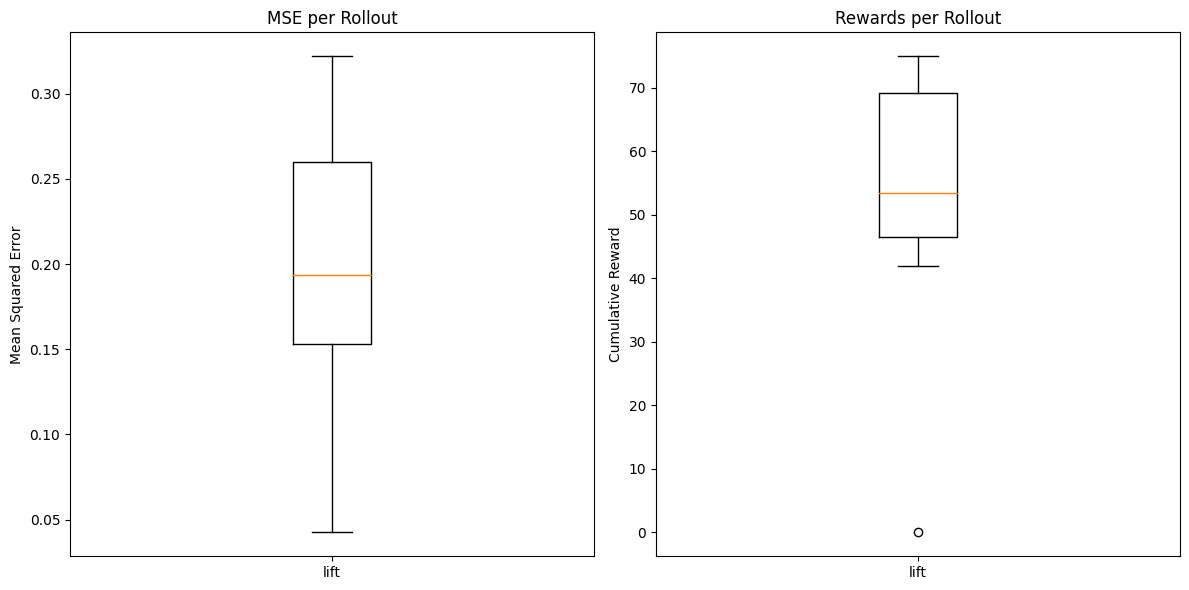

In [109]:
import matplotlib.pyplot as plt

mse_values = [mse_i for mse_i in total_mse_lift]
reward_values = [reward_i for reward_i in cumulative_reward_lift]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], [task_name_tested])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], [task_name_tested])

plt.tight_layout()
plt.show()


### Performance Can

In [95]:
total_mse_can, cumulative_reward_can = helper.evaluate_model(model, env, task_id_tested, data_path, horizon=200, num_rollouts=10, device=device)

Trajectory 0, MSE: 0.23766039111893947, Reward: 0.0
Trajectory 1, MSE: 0.45964934197027674, Reward: 0.0
Trajectory 2, MSE: 0.32930385200108636, Reward: 0.0
Trajectory 3, MSE: 0.11381716485243878, Reward: 88.0
Trajectory 4, MSE: 0.323344152440907, Reward: 0.0
Trajectory 5, MSE: 0.22548140376843268, Reward: 0.0
Trajectory 6, MSE: 0.13789917853321068, Reward: 80.0
Trajectory 7, MSE: 0.28528293212421657, Reward: 0.0
Trajectory 8, MSE: 0.312966884537333, Reward: 0.0
Trajectory 9, MSE: 0.02501583865886729, Reward: 64.0
Average MSE over 10 rollouts: 0.24504211400057088, Average Reward: 23.2


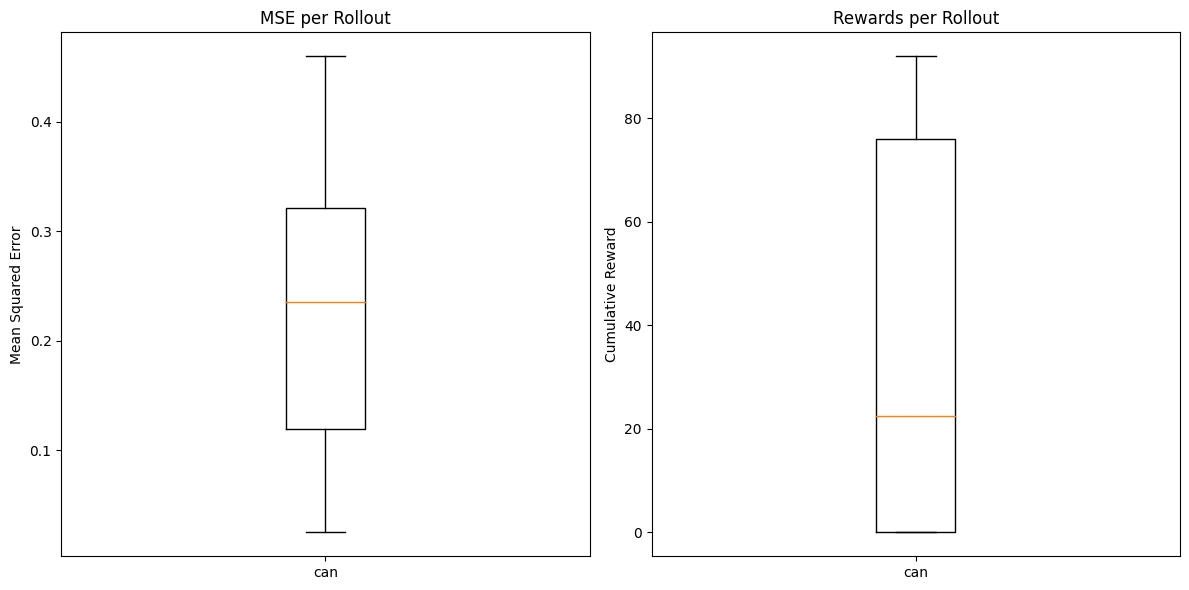

In [105]:
import matplotlib.pyplot as plt

mse_values = [mse_i for mse_i in total_mse_can]
reward_values = [reward_i for reward_i in cumulative_reward_can]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], [task_name_tested])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], [task_name_tested])

plt.tight_layout()
plt.show()


### Cumulative performance

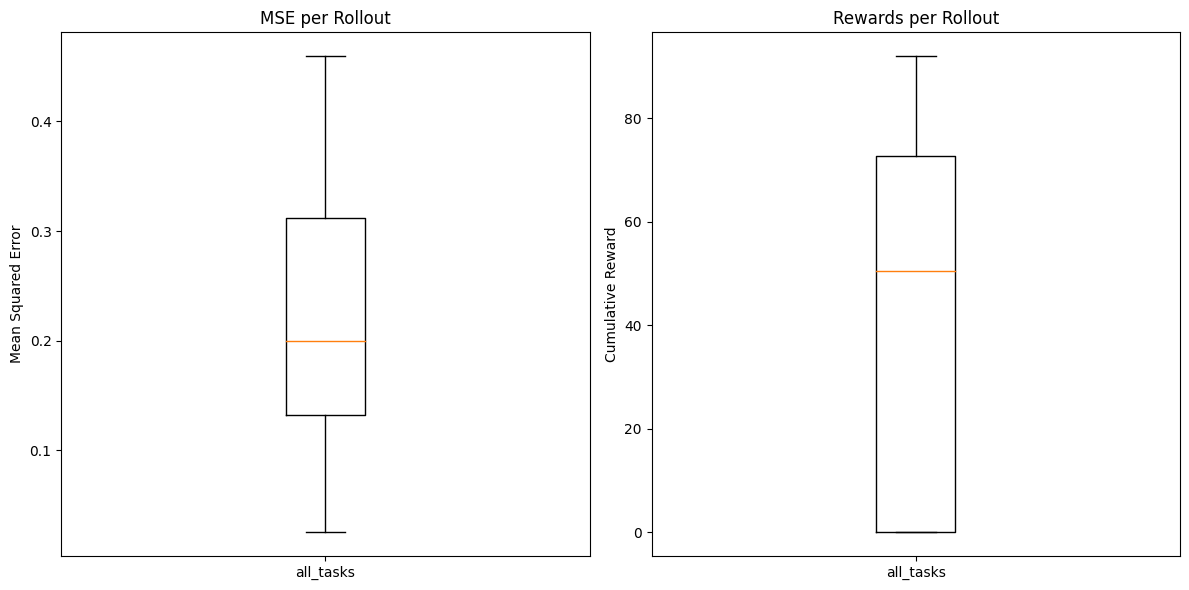

In [112]:
mse_values = [mse_i for mse_i in total_mse_lift] + [mse_i for mse_i in total_mse_can]
reward_values = [reward_i for reward_i in cumulative_reward_lift] + [reward_i for reward_i in cumulative_reward_can]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], ['all_tasks'])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], ['all_tasks'])

plt.tight_layout()
plt.show()

### Comparison with single task

In [152]:
# Results obtained from single task "can" model trained using the testing_algo_BC.py script
total_mse_can_single_task = [0.15, 0.2, 0.18, 0.16, 0.09, 0.13, 0.21, 0.22, 0.14, 0.23]
cumulative_reward_can_single_task = [50, 55, 40, 60, 45, 75, 80, 70, 55, 60]


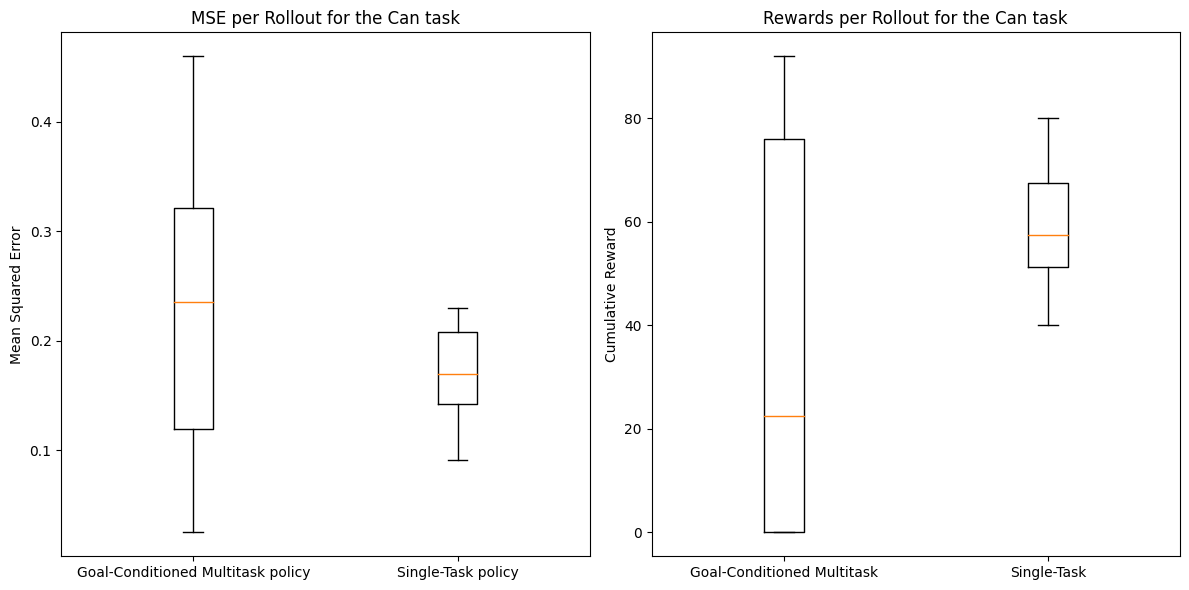

In [153]:
plt.figure(figsize=(12, 6))

# MSE Box Plot for both policies
plt.subplot(1, 2, 1)
plt.boxplot([total_mse_can, total_mse_can_single_task], labels=['Goal-Conditioned Multitask policy', 'Single-Task policy'])
plt.title('MSE per Rollout for the Can task')
plt.ylabel('Mean Squared Error')

# Reward Box Plot for both policies
plt.subplot(1, 2, 2)
plt.boxplot([cumulative_reward_can, cumulative_reward_can_single_task], labels=['Goal-Conditioned Multitask', 'Single-Task'])
plt.title('Rewards per Rollout for the Can task')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()


In [143]:
# Results obtained from single task "lift" model trained using the testing_algo_BC.py script
total_mse_lift_single_task = [0.210, 0.160, 0.050, 0.320, 0.170, 0.150, 0.095, 0.235, 0.180, 0.310]
cumulative_reward_lift_single_task = [74, 70, 50, 52, 35, 76, 55, 40, 60, 45]


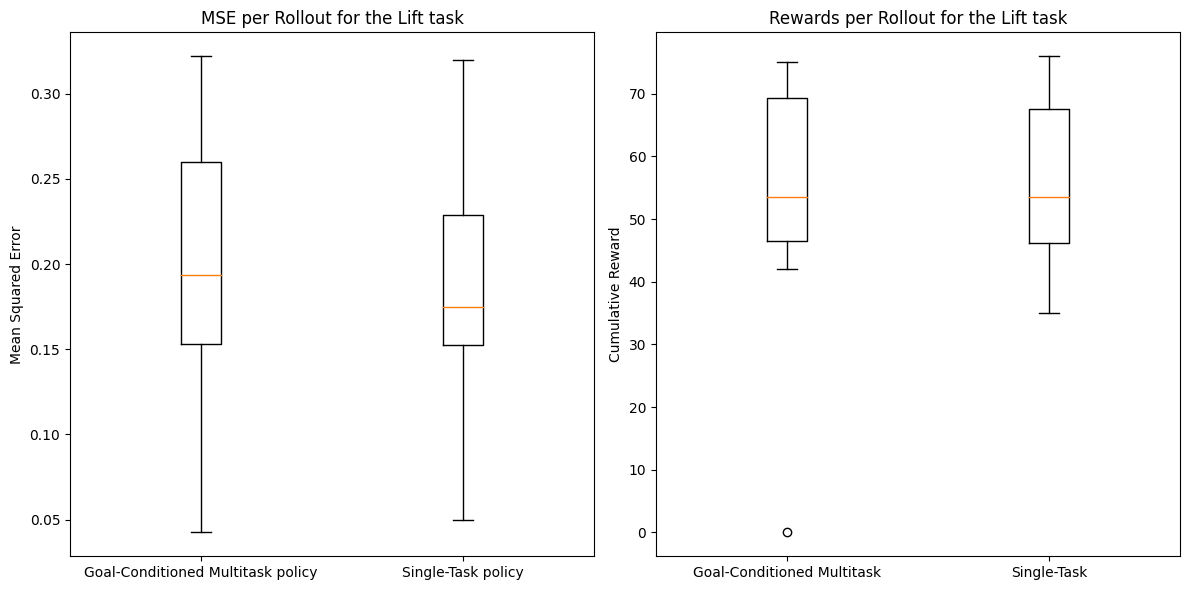

In [144]:
plt.figure(figsize=(12, 6))

# MSE Box Plot for both policies
plt.subplot(1, 2, 1)
plt.boxplot([total_mse_lift, total_mse_lift_single_task], labels=['Goal-Conditioned Multitask policy', 'Single-Task policy'])
plt.title('MSE per Rollout for the Lift task')
plt.ylabel('Mean Squared Error')

# Reward Box Plot for both policies
plt.subplot(1, 2, 2)
plt.boxplot([cumulative_reward_lift, cumulative_reward_lift_single_task], labels=['Goal-Conditioned Multitask', 'Single-Task'])
plt.title('Rewards per Rollout for the Lift task')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()
